<a href="https://colab.research.google.com/github/mohadi21/D-tection-des-marches-d-un-escalier-sur-une-image/blob/main/D%C3%A9tection_des_marches_d'un_escalier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import math

In [ ]:
# lissage

def filtrage_gaussien(img, taille_filtre=(5, 5)):
    return cv2.GaussianBlur(img,taille_filtre,0)

def filtrage_moyenne(img, taille_filtre=(5, 5)):
    return cv2.blur(img, taille_filtre)
    
def unsharp_mask(img, blur_size = (9,9), imgWeight = 1.5, gaussianWeight = -0.5):
    gaussian = cv2.GaussianBlur(img, (5,5), 0)
    return cv2.addWeighted(img, imgWeight, gaussian, gaussianWeight, 0)

In [ ]:
# Binaraisation

def binaraisation(img, v1=5, methode=cv2.ADAPTIVE_THRESH_GAUSSIAN_C):
    return cv2.adaptiveThreshold(img, 255, methode, cv2.THRESH_BINARY_INV, v1, 2)

In [ ]:
# Calculer les lignes
def lignes_hough(img):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 10 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100  # minimum number of pixels making up a line
    max_line_gap = 40 # maximum gap in pixels between connectable line segments
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

# Selectionner les lignes horizontales
def horizontal_lines(lines, error = 0):
    lines = lines.reshape((lines.shape[0], lines.shape[2]))
    lines_hor = []
    for x1, y1, x2, y2 in lines:
        alpha = 0
        a = np.abs(y2 - y1)
        b = np.abs(x2 - x1)
        if a == 0 :
            alpha = 0
        if b == 0:
            alpha = 180
        else:
            alpha = math.degrees(math.atan(a/b))
        if alpha <= error:
            lines_hor.append([[x1, y1, x2, y2]])
    return np.array(lines_hor)

In [ ]:
# Affichage 
def afficher_image(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.show()
    
def afficher_ligne(img, lines):
    line_image = np.copy(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
    lines_edges = cv2.addWeighted(img, 0.5, line_image, 1, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(lines_edges, cmap='gray')
    plt.savefig("/content/sample_data/img.png")
    plt.show()
    print(lines_edges.shape)

In [ ]:
def distance_verticale(ligne1, ligne2):
    x1, y1, x2, y2 = ligne1
    x1_, y1_, x2_, y2_ = ligne2
    return math.abs(x1 - x1_)
    
def trier_par_axe(lignes):
    lignes = lignes.copy()
    for i in range(len(lignes) - 1):
        for j in range(i+1, len(lignes)):
            if lignes[i, 0, 1] < lignes[j, 0, 1]:
                x = lignes[i, 0, :].copy()
                lignes[i, 0, :] = lignes[j, 0, :]
                lignes[j, 0, :] = x
    return lignes

def min_x(lignes):
    minx = lignes[0, 0, 0]
    for i in range(1, len(lignes)):
        if minx > lignes[i, 0, 0]:
            minx = lignes[i, 0, 0]
    return minx 

def min_y(lignes):
    miny = lignes[0, 0, 1]
    for i in range(1, len(lignes)):
        if miny > lignes[i, 0, 1]:
            miny = lignes[i, 0, 1]
    return miny 
            
def max_x(lignes):
    maxx = lignes[0, 0, 2]
    for i in range(1, len(lignes)):
        if maxx < lignes[i, 0, 2]:
            maxx = lignes[i, 0, 2]
    return maxx 


def max_y(lignes):
    maxy = lignes[0, 0, 3]
    for i in range(1, len(lignes)):
        if maxy < lignes[i, 0, 3]:
            maxy = lignes[i, 0, 3]
    return maxy 
            
            

def regrouper_plus_proche(lignes, seuil):
    new_lignes_dic = {}
    visiter = {}
    l = 0
    for i in range(len(lignes)-1):
        if i in visiter:
            continue
        else:
            l += 1
            seuil = seuil * 0.9
            new_lignes_dic[l] = [i]
            visiter[i] = ""
            for j in range(i+1, len(lignes)):
                dist = abs(lignes[i, 0, 1] -lignes[j, 0, 1])
                if dist < seuil :
                    new_lignes_dic[l].append(j)
                    visiter[j] = ""
    new_lignes = []
    for num, l in new_lignes_dic.items():
        minx = min_x(lignes[l, :, :])
        maxx = max_x(lignes[l, :, :])
        miny = min_y(lignes[l, :, :])
        maxy = max_y(lignes[l, :, :])
        moyy = int(miny + (maxy - miny)/2)
        new_lignes.append([minx, moyy, maxx, moyy])
    new_lignes = np.array(new_lignes)
    return new_lignes.reshape((new_lignes.shape[0], 1, new_lignes.shape[1]))
            

In [ ]:
def calcule_marche_contre_marche(lignes, seuil=3):
    visiter = {}
    marche = {}
    m = 0
    for i in range(len(lignes)-1):
        if i in visiter:
            continue
        else:
            visiter[i] = ""
            marche[m] = [i]
            for j in range(i+1, len(lignes)):
                distx1 = abs(lignes[i, 0, 0] - lignes[j, 0, 0])
                distx2 = abs(lignes[i, 0, 3] - lignes[j, 0, 3])
                if distx1 <= seuil or distx2 <= seuil:
                    marche[m].append(j)
                    visiter[j] = ""
            m += 1
    return m-1

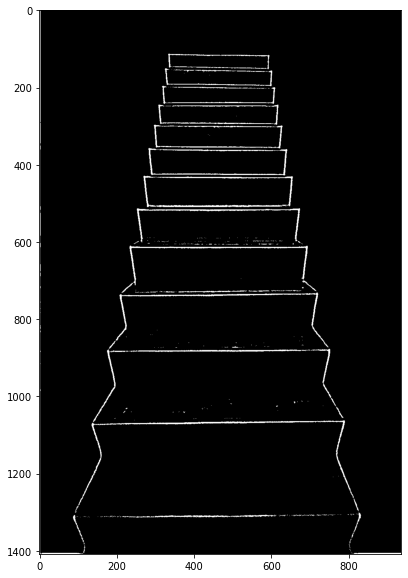

In [ ]:
image = cv2.imread("/content/sample_data/img11.jpg")
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = unsharp_mask(gray)
gray = unsharp_mask(gray)

gray = filtrage_moyenne(gray)
gray = filtrage_gaussien(gray)
binr = binaraisation(gray)
afficher_image(binr)

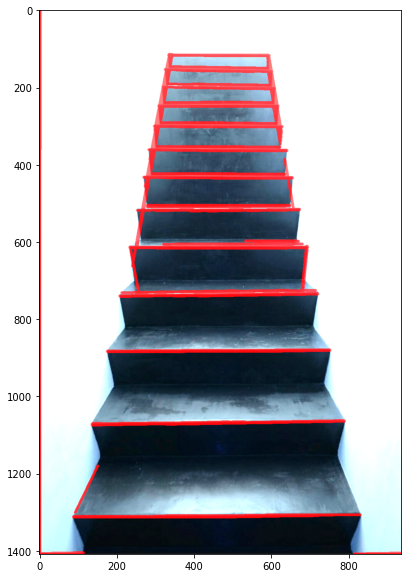

(1408, 936, 3)


In [ ]:
lignes_h = lignes_hough(binr)
afficher_ligne(image, lignes_h)


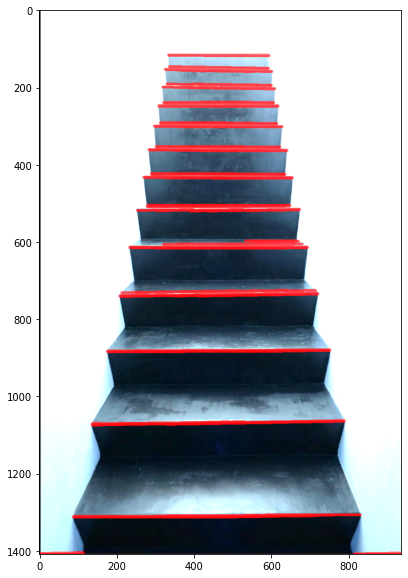

(1408, 936, 3)


In [ ]:
lignes = horizontal_lines(lignes_h, 40)
afficher_ligne(image, lignes)


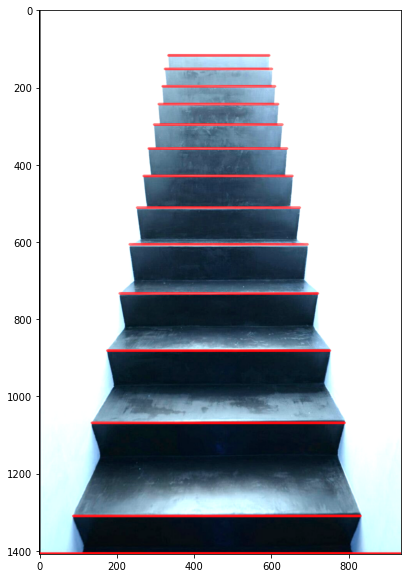

(1408, 936, 3)
marches = 12


In [ ]:

lignes_ = regrouper_plus_proche(lignes, 40)
afficher_ligne(image, lignes_)
m = calcule_marche_contre_marche(lignes_, seuil=4)
print(f"marches = {m}")